Rodrigo García Salado

---
### PRÁCTICA 2
---

Ponemos los imports

In [1]:
#imports

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram


Importamos el archivo

In [2]:
# Cargamos el archivo
data_df = pd.read_csv("Practica2/semillas.csv") 

Ahora observamos cuantos y qué tipo de datos vamos a estar tratando


In [3]:

print('The shape of the data table is:')
print('===============================')
print(data_df.shape)
print()

print('The types of the attributes are:')
print('================================')
data_df.info()

print()

print('How many missing values per attribute:')
print('======================================')
print(data_df.isnull().sum())

print()

print('Fraction of missing values per attribute:')
print('======================================')
print(data_df.isnull().mean())


The shape of the data table is:
(210, 8)

The types of the attributes are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        210 non-null    float64
 1   perimetro   210 non-null    float64
 2   compacidad  210 non-null    float64
 3   longitud    210 non-null    float64
 4   anchura     210 non-null    float64
 5   asimetria   210 non-null    float64
 6   surco       210 non-null    float64
 7   clase       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB

How many missing values per attribute:
area          0
perimetro     0
compacidad    0
longitud      0
anchura       0
asimetria     0
surco         0
clase         0
dtype: int64

Fraction of missing values per attribute:
area          0.0
perimetro     0.0
compacidad    0.0
longitud      0.0
anchura       0.0
asimetria     0.0
surco         0.0
clase     

In [4]:
SEMILLA = 100478705


# Separar características y etiquetas
X = data_df.drop(columns=['clase']) 
y = data_df['clase']

# Lista de scalers a comparar
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}



creamos la figura para comparar


StandardScaler
Varianza explicada por componente 1: 0.7187
Varianza explicada por componente 2: 0.1711
Varianza total explicada (2 componentes): 0.8898


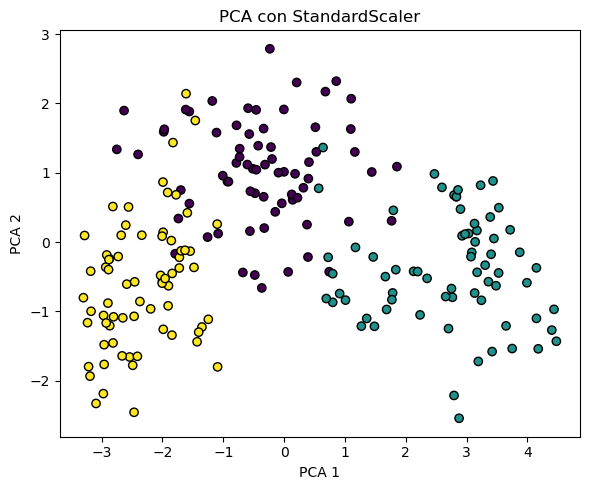


MinMaxScaler
Varianza explicada por componente 1: 0.7890
Varianza explicada por componente 2: 0.1291
Varianza total explicada (2 componentes): 0.9181


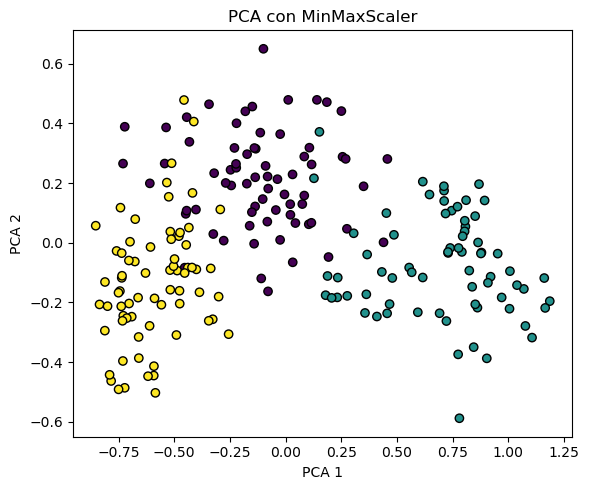


RobustScaler
Varianza explicada por componente 1: 0.6695
Varianza explicada por componente 2: 0.1996
Varianza total explicada (2 componentes): 0.8691


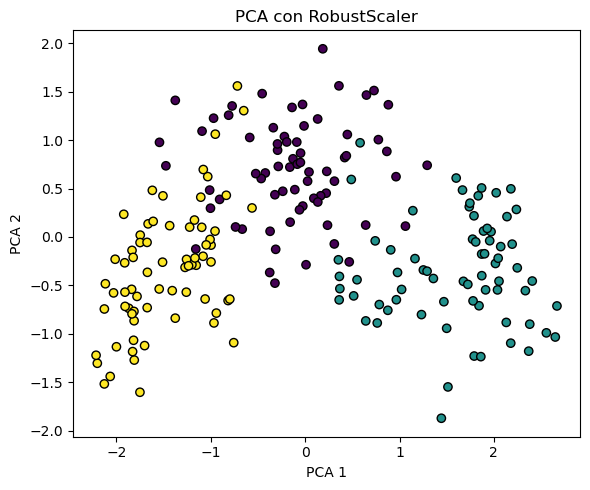

In [5]:
# Iterar sobre los scalers y graficar uno a uno
for name, scaler in scalers.items():
    # Crear pipeline: scaler + PCA con semilla
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state = SEMILLA))
    ])

    # Transformar los datos
    X_pca = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']  # acceder al PCA para consultar la varianza

    # Varianza explicada
    explained_var = pca.explained_variance_ratio_
    total_explained = np.sum(explained_var)

    print(f"\n{name}")
    print(f"Varianza explicada por componente 1: {explained_var[0]:.4f}")
    print(f"Varianza explicada por componente 2: {explained_var[1]:.4f}")
    print(f"Varianza total explicada (2 componentes): {total_explained:.4f}")

    # Graficar
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')
    plt.title(f'PCA con {name}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.tight_layout()
    plt.show()

In [6]:
# Escalado con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reducción con PCA a 2 componentes
pca = PCA(n_components=2, random_state=SEMILLA)
X_pca = pca.fit_transform(X_scaled)

# K-means

Primero medimos el numero de clusters

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=SEMILLA)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))





Medimos la inercia mediante el metodo del codo

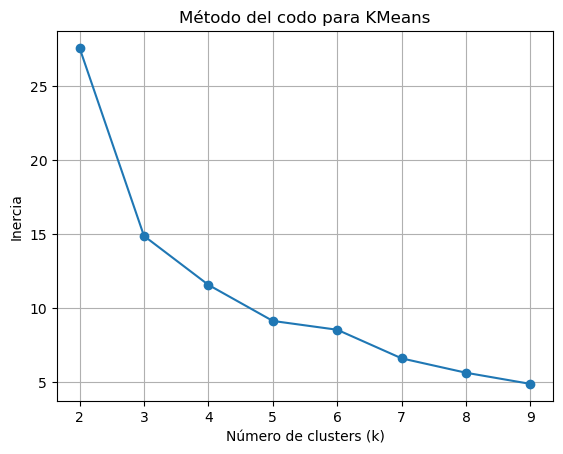

In [8]:
# Gráfico del método del codo
plt.figure()
plt.plot(K, inertia, 'o-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para KMeans')
plt.grid()
plt.show()

Y la distancia entre un cluster y otro por medio del coeficiente de silueta

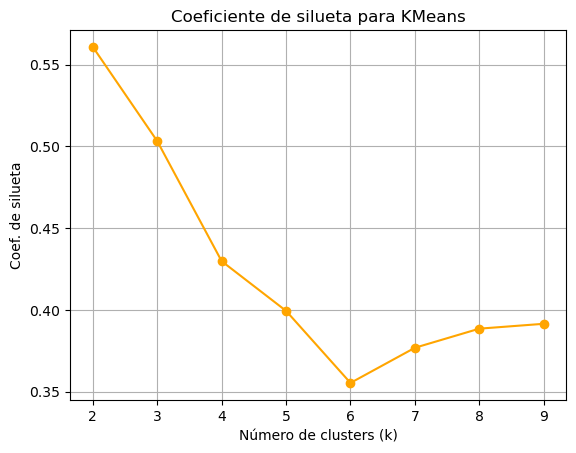

k   |  silhouette
------------------
 2  |  0.5607
 3  |  0.5032
 4  |  0.4297
 5  |  0.3994
 6  |  0.3553
 7  |  0.3768
 8  |  0.3885
 9  |  0.3914

Silhouette para k = 2 → 0.5607
Máximo global: k = 2  (silhouette = 0.5607)


In [9]:
# Gráfico del coeficiente de silueta
plt.figure()
plt.plot(K, silhouette, 'o-', color='orange')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coef. de silueta')
plt.title('Coeficiente de silueta para KMeans')
plt.grid()
plt.show()


print("k   |  silhouette")
print("------------------")
for k, sil in zip(K, silhouette):
    print(f"{k:>2}  |  {sil:.4f}")

# · Silhouette concreta para k = 2
sil_k2 = silhouette[K.index(2)]
print(f"\nSilhouette para k = 2 → {sil_k2:.4f}")

# · Mejor k según la métrica
best_idx = np.argmax(silhouette)
print(f"Máximo global: k = {K[best_idx]}  (silhouette = {silhouette[best_idx]:.4f})")


Aunque el valor más alto del coeficiente de silueta se obtiene con k=2, el método del codo muestra claramente un punto de inflexión en k=3, donde la inercia comienza a disminuir.

Además, el valor de silueta en k=3 sigue siendo razonablemente alto, lo que sugiere una buena separación entre los clusters. Por tanto, optamos por aplicar KMeans con k=3

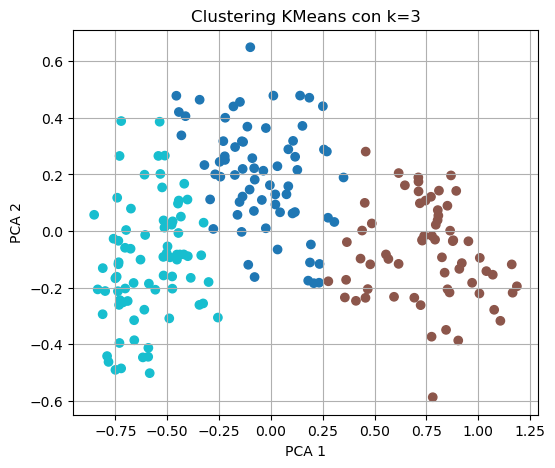

In [10]:
k_opt = 3

kmeans = KMeans(n_clusters=k_opt, random_state=SEMILLA)
kmeans_labels = kmeans.fit_predict(X_pca)

# Visualizar los clusters encontrados
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10')
plt.title(f'Clustering KMeans con k={k_opt}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid()
plt.show()


# Clustering jerárquico / aglomerativo

Comparamos funciones de linkages con numeros de clusters para quedarnos con el mejor

In [11]:
linkages = ['ward', 'complete', 'average', 'single']
k_range  = range(2, 7)
results  = []

for link in linkages:
    for k in k_range:
        labels = AgglomerativeClustering(n_clusters=k, linkage=link).fit_predict(X_pca)
        sil = silhouette_score(X_pca, labels) if len(np.unique(labels)) > 1 else np.nan
        results.append((link, k, sil))

res_df = pd.DataFrame(results, columns=['linkage', 'k', 'silhouette'])
best_link, best_k = res_df.loc[res_df['silhouette'].idxmax(), ['linkage', 'k']]

print(f"Mejor → linkage = {best_link}, k = {best_k}, silhouette = "
      f"{res_df['silhouette'].max():.4f}")
display(res_df.pivot(index='linkage', columns='k', values='silhouette'))


Mejor → linkage = complete, k = 2, silhouette = 0.5610


k,2,3,4,5,6
linkage,,,,,
average,0.553146,0.475209,0.442024,0.400086,0.374341
complete,0.561016,0.347537,0.298043,0.234060,0.251242
single,0.215319,-0.111247,-0.206330,-0.375573,-0.005708
ward,0.465420,0.471405,0.445104,0.385002,0.395824


Optamos por el linkage complete con k = 2 clusters.

En complete la distancia entre dos clusters se define como la máxima distancia entre cualquiera de sus puntos, el hecho de que esta configuración obtenga la silhouette más alta sugiere que no hay muchos outliers (puntos muy alejados de la nube principal), porque complete es sensible a ellos.

Ahora mostramos en una gráfica cómo se han agrupado los datos:

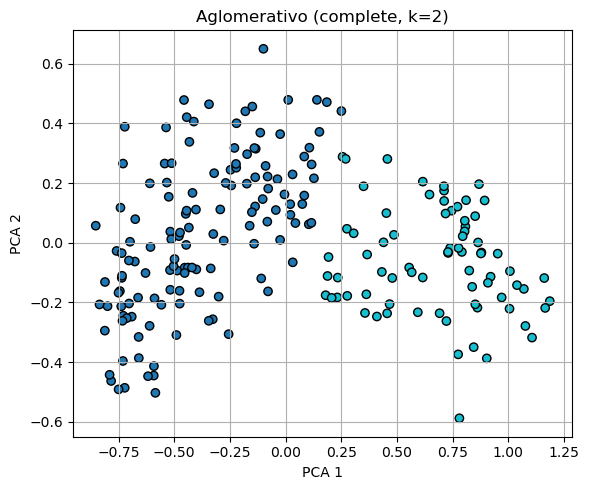

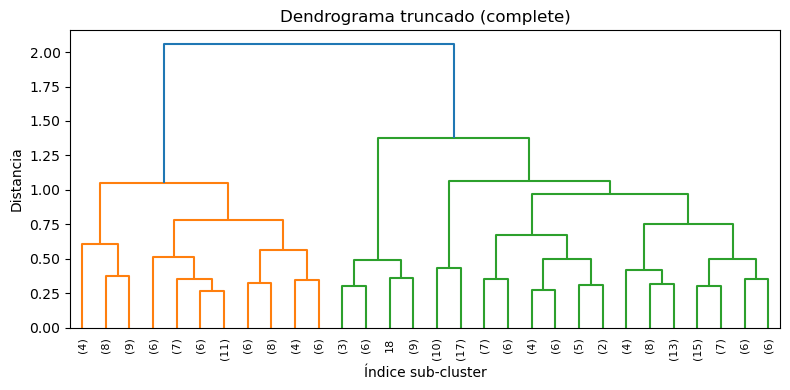

In [12]:

best_labels = AgglomerativeClustering(n_clusters=best_k, linkage=best_link).fit_predict(X_pca)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='tab10', edgecolor='k')
plt.title(f'Aglomerativo ({best_link}, k={best_k})')
plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.grid(); plt.tight_layout()
plt.show()

Z = linkage(X_pca, method=best_link)
plt.figure(figsize=(8, 4))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=8.)
plt.title(f'Dendrograma truncado ({best_link})')
plt.xlabel('Índice sub-cluster'); plt.ylabel('Distancia'); plt.tight_layout()
plt.show()


# DBSCAN

Lo primero es elegir el min_samples, para ello hemos hecho uso de 2 x D siendo "D" el numero de dimensiones de nuestro conjunto de datos después del PCA

In [13]:
min_samples = 4

Para calcular un buen rango de vecindad calculamos las distancias de todos los puntos entre sí quedandonos con las 4 primeras muestras

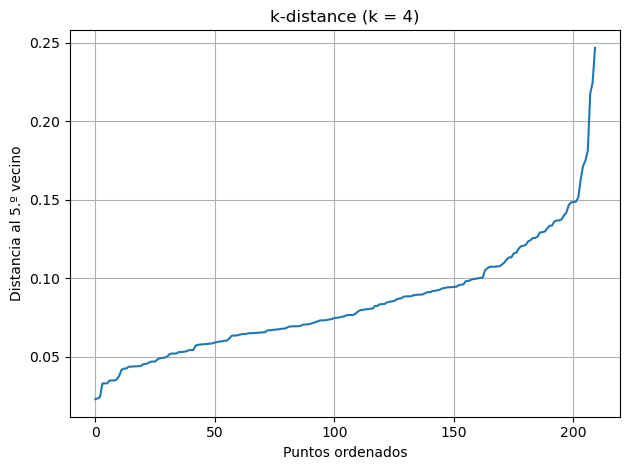

In [14]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_pca)
# Distancia al 4.º vecino más cercano de cada punto
distances, _ = nn.kneighbors(X_pca)
k_distances = np.sort(distances[:, -1])          
plt.figure()
plt.plot(k_distances)
plt.title(f'k-distance (k = {min_samples})')
plt.xlabel('Puntos ordenados'); plt.ylabel('Distancia al 5.º vecino')
plt.grid(); plt.tight_layout(); plt.show()



Esta gráfica muestra nuestros 210 elementos ordenados de menos a mayor distancia con respecto a sus 4 vecinos, a más distancia, entorno menos denso y a menor, más denso. A partir de aproximadamente el punto 200 comienzan las muestras más aisladas.

Podemos ver que aproximadamente el 80% o el 90% de nuestros datos se encuentran juntos en áreas de mucha densidad, por lo que utilizaremos éstos datos como rango eps.

In [15]:
eps_min = np.percentile(k_distances, 80)
eps_max = np.percentile(k_distances, 90)
eps_grid = np.linspace(eps_min, eps_max, 10)

#Grid search sobre eps 

results = []
for eps in eps_grid:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_pca)

    # nº clusters (sin contar ruido) y nº puntos etiquetados como ruido
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise    = np.sum(labels == -1)

    # Silhouette: solo si hay ≥ 2 clusters reales
    if n_clusters >= 2:
        sil = silhouette_score(X_pca[labels != -1], labels[labels != -1])
    else:
        sil = np.nan

    results.append((eps, n_clusters, n_noise, sil))

res_db = pd.DataFrame(
    results, columns=['eps', 'clusters', 'noise', 'silhouette']
)

best_idx = res_db['silhouette'].idxmax()
best_eps = res_db.loc[best_idx, 'eps']
best_sil = res_db.loc[best_idx, 'silhouette']
best_clusters = int(res_db.loc[best_idx, 'clusters'])
best_noise = int(res_db.loc[best_idx, 'noise'])

print(f"Mejor eps = {best_eps:.3f}  |  clusters = {best_clusters}  |  "
      f"ruido = {best_noise}  |  silhouette = {best_sil:.3f}")
display(res_db)


Mejor eps = 0.107  |  clusters = 4  |  ruido = 21  |  silhouette = 0.477


,eps,clusters,noise,silhouette
0,0.107325,4,21,0.476997
1,0.109835,3,20,0.430372
2,0.112345,3,20,0.430372
3,0.114855,3,20,0.430372
4,0.117365,3,19,0.430763
5,0.119875,3,18,0.433676
6,0.122385,3,16,0.429713
7,0.124896,3,16,0.429713
8,0.127406,3,14,0.427154
9,0.129916,4,9,0.373538


Podemos ver que el mejor valor se encuentra en nuestra primera fila con la máxima compactación y un eps de 0.107.

Hacemos uso de la gráfica para fijarnos bien en los clusters seleccionados por éste método. 
(He usado IA generativa para ayudarme a hacer la gráfica)

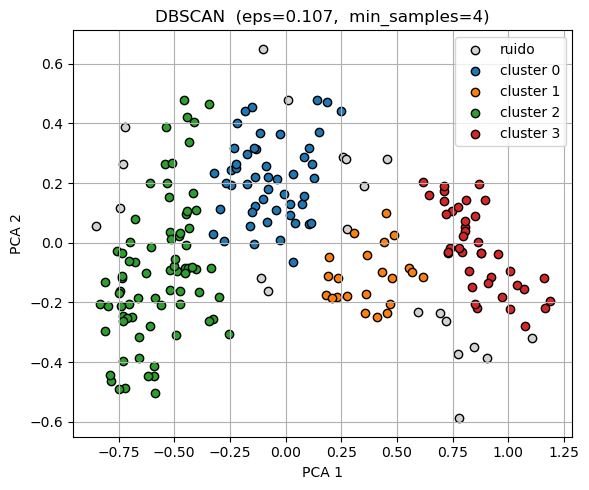

In [16]:

db_best   = DBSCAN(eps=best_eps, min_samples=min_samples)
labels_db = db_best.fit_predict(X_pca)

plt.figure(figsize=(6, 5))
unique_lab = np.unique(labels_db)
for lab in unique_lab:
    mask = labels_db == lab
    if lab == -1:           
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c='lightgrey', edgecolor='k', label='ruido')
    else:
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    label=f'cluster {lab}', edgecolor='k')

plt.title(f'DBSCAN  (eps={best_eps:.3f},  min_samples={min_samples})')
plt.xlabel('PCA 1'); plt.ylabel('PCA 2')
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()


---
# Cual de los métodos captura mejor la estructura de cluster


- El mejor de DBSCAN es 0.4769
- El mejor de Clustering jerárquico es 0.5610
- El mejor de K-means es 0.5032 (por que escogimos K = 3)

Teniendo éstos datos en cuenta nos fijamos que el mayor valor lo tiene el método de Clustering jerárquico por medio del algoritmo complete con numero de clusters K = 2

Ahora mediremos nuestro modelo con las clases reales

Adjusted Rand Index (K-Means vs. clase): 0.491


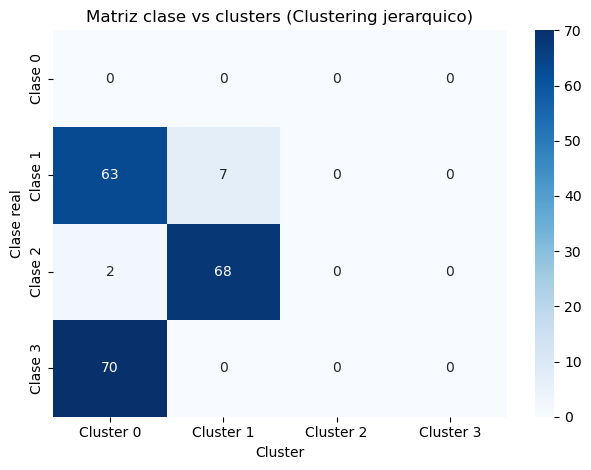

In [17]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, numpy as np

ari = adjusted_rand_score(y, best_labels)
print(f"Adjusted Rand Index (K-Means vs. clase): {ari:.3f}")

true_labels = np.sort(y.unique())                    # clases reales
pred_labels = np.sort(np.unique(best_labels))      # clusters 0,1,2 …

all_labels = np.union1d(true_labels, pred_labels)   

cm = confusion_matrix(y, best_labels, labels=all_labels)

df_cm = pd.DataFrame(
    cm,
    index   = [f"Clase {c}"   for c in all_labels],   # filas: clases reales
    columns = [f"Cluster {c}" for c in all_labels]    # columnas: labels predichos
)

# 4. Heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz clase vs clusters (Clustering jerarquico)")
plt.ylabel("Clase real")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()


Como podemos ver en nuestro conjunto poseíamos 3 clases en lugar de 2, nuestro método más eficaz (clustering jerárquico) ha mezclado 2 clases en una.

Podemos probar por el método de DBSCAN

Adjusted Rand Index (K-Means vs. clase): 0.578


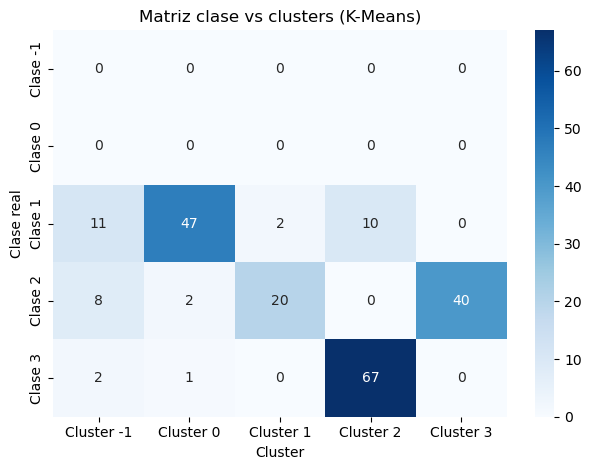

In [18]:

ari = adjusted_rand_score(y, labels_db)
print(f"Adjusted Rand Index (K-Means vs. clase): {ari:.3f}")

true_labels = np.sort(y.unique())                    # clases reales
pred_labels = np.sort(np.unique(labels_db))      # clusters

all_labels = np.union1d(true_labels, pred_labels)    # unión ordenada

cm = confusion_matrix(y, labels_db, labels=all_labels)

df_cm = pd.DataFrame(
    cm,
    index   = [f"Clase {c}"   for c in all_labels],   # filas: clases reales
    columns = [f"Cluster {c}" for c in all_labels]    # columnas: labels predichos
)

# 4. Heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz clase vs clusters (K-Means)")
plt.ylabel("Clase real")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()


Como nuestro método poseía un K = 4 ha fallado más que el anterior en predecir los clusters.

 Si por otro lado utilizamos k-means que es nuestro segundo mejor valor con un K = 3:

Adjusted Rand Index (K-Means vs. clase): 0.705


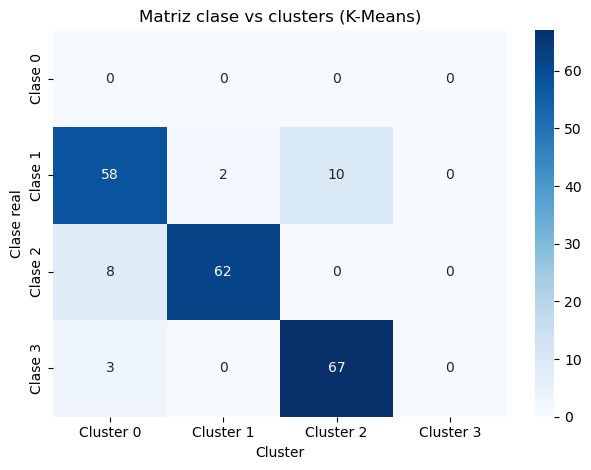

In [19]:

ari = adjusted_rand_score(y, kmeans_labels)
print(f"Adjusted Rand Index (K-Means vs. clase): {ari:.3f}")

true_labels = np.sort(y.unique())                    # clases reales
pred_labels = np.sort(np.unique(kmeans_labels))      # clusters

all_labels = np.union1d(true_labels, pred_labels)    # unión ordenada

cm = confusion_matrix(y, kmeans_labels, labels=all_labels)

df_cm = pd.DataFrame(
    cm,
    index   = [f"Clase {c}"   for c in all_labels],   # filas: clases reales
    columns = [f"Cluster {c}" for c in all_labels]    # columnas: labels predichos
)

# 4. Heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz clase vs clusters (K-Means)")
plt.ylabel("Clase real")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()


falla en más datos que el anterior, pero acierta con el numero de clusters final. Podemos concluir por tanto que el K-means ha capturado mejor nuestra estructura de clusters.

Cabe destacar que si escogemos un K = 3 en el resto de nuestros métodos nos daba un silhouette mucho menos que el del k-means

Por último interpretamos los clusters optenidos de K_means con boxplot:

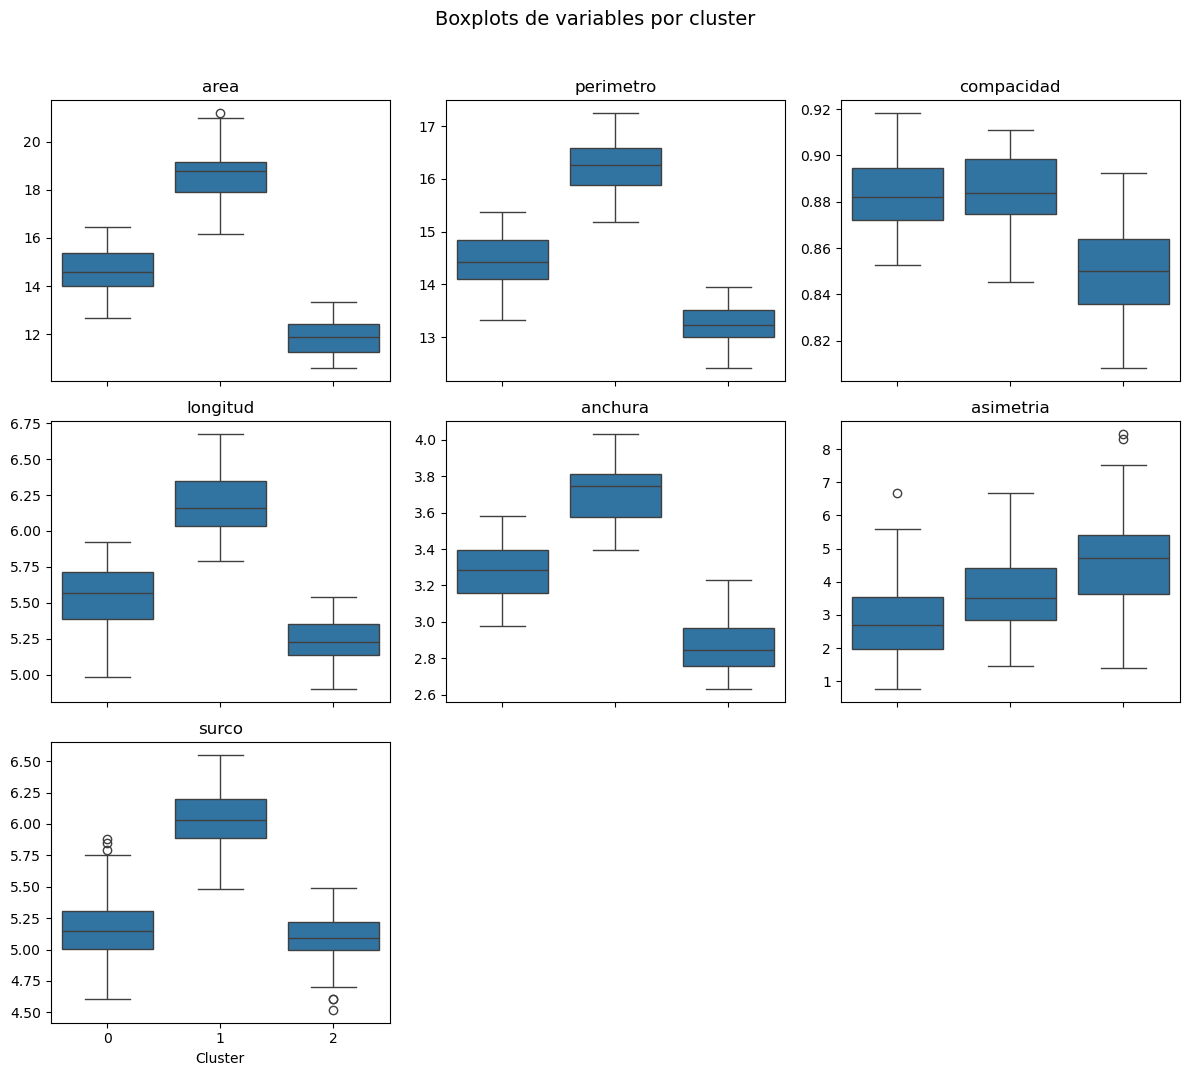

In [20]:


# mi mejor algoritmo
label_set = kmeans_labels        

vars_originales = X.columns.tolist()  
n_vars = len(vars_originales)
n_cols = 3                                  
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows), sharex=True)
axes = axes.flatten()                        

for i, col in enumerate(vars_originales):
    sns.boxplot(x=label_set, y=data_df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel("")                 

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplots de variables por cluster", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()



Para el Kmeans podemos ver que los valores de área y perímetro son los más importantes a la hora de generar los clusters, mientras que otras variables como asimetría, no se diferencian nada, igual que el surco entre el cluster 0 y el 2.